# Requerimientos para módulo Receptor (RX)
### Instituto Tecnologico de Costa Rica
### Escuela de Ingeniería Electrónica
### Curso: Taller de Comunicaciones Eléctricas
### Estudiantes:
- Esteban Arias Rojas
- David Herrera Castro
- David Monge Naranjo
- Federico Rivera Moya

## Bloque Visualización

In [1]:
#Se definen los imports necesarios para el código
import pandas as pd
import spotpy
import matplotlib.pyplot as plt
import math
import time
from tabulate import tabulate
from sklearn.metrics import mean_squared_error 

In [2]:
# Dataset original transmitido
archivo_excel = 'Dataset.xlsx'

# Lee el archivo Excel y crea un DataFrame
data_frame = pd.read_excel(archivo_excel)

# Datos completos
print(data_frame)

tiempo = data_frame.iloc[:, 0]
bpm = data_frame.iloc[:, 1]


     Tiempo(s)         BPM
0            0   90.435881
1           10   91.375558
2           20   93.177147
3           30   92.253070
4           40   93.297168
..         ...         ...
122       1220  127.489200
123       1230  125.722564
124       1240  125.176371
125       1250  124.053356
126       1260  123.681245

[127 rows x 2 columns]


In [3]:
#Datos reales
archivo_reales = 'Dataset_2023_Reales.xlsx'
data_reales = pd.read_excel(archivo_reales)

#Datos recibidos por Hamming 7-4  
archivo_deco74 = 'decodificados_74.xlsx'
data_deco74 = pd.read_excel(archivo_deco74)
 
#Datos recibidos por Hamming 15-11 
archivo_deco1511 = 'decodificados_1511.xlsx'
data_deco1511 = pd.read_excel(archivo_deco1511)


### Zonas de entrenamiento

| Zonas                  | % FC      | PE    |
|------------------------|-----------|-------|
| Zona 1 (Calentamiento) | < 65 %    | 2     |
| Zona 2 (Quemar Grasa)  | 65-80 %   | 3 - 4 |
| Zona 3 (Aeróbico)      | 80-85 %   | 7     |
| Zona 4 (Anaeróbico)    | 85-90 %   | 8 - 9 |
| Zona 5 (Extrema)       | > 95 %    | 10    |

Fuente: https://www.triatlonnoticias.com/entrenamientos-triatlon/que-son-las-zonas-de-entrenamiento/#google_vignette


**Para la gráfica de zona de entrenamiento se utiliza lo que son los datos obtenidos apartir de la decodificación 15-11, ya que su RMSE es bajo y su Pbias es mucho menor que el Pbias de la decodificación 7-4. Además de que con esta decodificación se obtiene un mejor BER**

In [4]:
# Calcula el valor máximo en la columna "bpm"
maximo = data_deco1511['BPM_Decodificados_15_11'].max()

# Se establecen las zonas según los datos de la referencia
data_deco1511.loc[data_deco1511['BPM_Decodificados_15_11'] <= 0.65 * maximo, 'Zonas'] = 1  # Calentamiento
data_deco1511.loc[(data_deco1511['BPM_Decodificados_15_11'] <= 0.80 * maximo) & (0.65 * maximo < data_deco1511['BPM_Decodificados_15_11']), 'Zonas'] = 2  # Quemar grasa
data_deco1511.loc[(data_deco1511['BPM_Decodificados_15_11'] <= 0.85 * maximo) & (0.80 * maximo < data_deco1511['BPM_Decodificados_15_11']), 'Zonas'] = 3  # Aeróbico
data_deco1511.loc[(data_deco1511['BPM_Decodificados_15_11'] <= 0.95 * maximo) & (0.85 * maximo < data_deco1511['BPM_Decodificados_15_11']), 'Zonas'] = 4  # Anaeróbico
data_deco1511.loc[0.95 * maximo <= data_deco1511['BPM_Decodificados_15_11'], 'Zonas'] = 5  # Extrema

# Imprime el DataFrame resultante
print(data_deco1511)

     BPM_Decodificados_15_11  Zonas
0                         91    1.0
1                         92    1.0
2                         92    1.0
3                         93    1.0
4                         94    1.0
..                       ...    ...
122                       95    1.0
123                      126    2.0
124                      125    2.0
125                      125    2.0
126                      112    2.0

[127 rows x 2 columns]


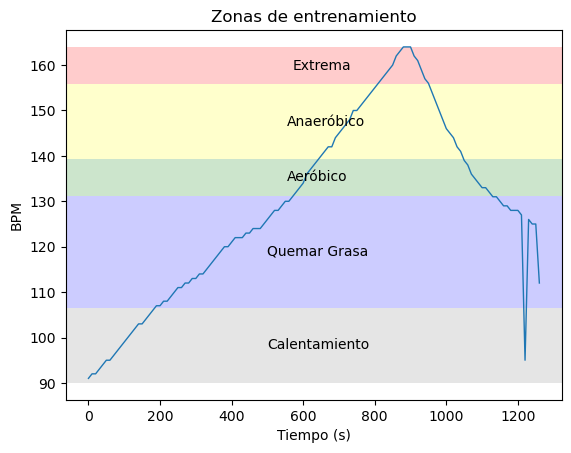

In [5]:
#Se grafica las zonas de entrenamiento según los datos obtenidos en el decodificador

plt.plot(data_frame['Tiempo(s)'],data_deco1511['BPM_Decodificados_15_11'], linewidth = 1) #Se grafican los datos BPM vs Tiempo

# Define los límites de las zonas
zona1 = (90, 0.65 * maximo)
zona2 = (0.65 * maximo, 0.80 * maximo)
zona3 = (0.80 * maximo, 0.85 * maximo)
zona4 = (0.85 * maximo, 0.95 * maximo)
zona5 = (0.95 * maximo, 1 * maximo)

# Dibuja las zonas y etiquetas en el centro
plt.axhspan(*zona1, facecolor='gray', alpha=0.2)
plt.text(500, (zona1[0] + zona1[1]) / 2, 'Calentamiento', ha='left', va='center')

plt.axhspan(*zona2, facecolor='blue', alpha=0.2)
plt.text(500, (zona2[0] + zona2[1]) / 2, 'Quemar Grasa', ha='left', va='center')

plt.axhspan(*zona3, facecolor='green', alpha=0.2)
plt.text(555, (zona3[0] + zona3[1]) / 2, 'Aeróbico', ha='left', va='center')

plt.axhspan(*zona4, facecolor='yellow', alpha=0.2)
plt.text(555, (zona4[0] + zona4[1]) / 2, 'Anaeróbico', ha='left', va='center')

plt.axhspan(*zona5, facecolor='red', alpha=0.2)
plt.text(570, (zona5[0] + zona5[1]) / 2, 'Extrema', ha='left', va='center')

plt.axvline(x=200, ymin=90, ymax=0.65 * maximo, color='black')

plt.ylabel('BPM')
plt.xlabel('Tiempo (s)')
plt.title('Zonas de entrenamiento')

# Muestra el gráfico
plt.show()

In [6]:
# Crear un diccionario para almacenar los rangos de tiempo por zona
zonas_tiempo = {
    1: [],
    2: [],
    3: [],
    4: [],
    5: []
}

# Inicializar variables para realizar un seguimiento de los cambios de zona
zona_actual = data_deco1511.at[0, 'Zonas']
inicio_rango = data_frame.at[0, 'Tiempo(s)']

# Iterar a través del DataFrame
for i in range(1, len(data_deco1511)):
    zona_actual = data_deco1511.at[i, 'Zonas']
    if zona_actual != data_deco1511.at[i-1, 'Zonas']:
        zona_actual = data_deco1511.at[i-1, 'Zonas']
        fin_rango = data_frame.at[i - 1, 'Tiempo(s)']
        zonas_tiempo[zona_actual].append((inicio_rango, fin_rango))
        inicio_rango = data_frame.at[i, 'Tiempo(s)']

# Agregar el último rango de tiempo
fin_rango = data_frame.at[len(data_frame) - 1, 'Tiempo(s)']
zonas_tiempo[zona_actual].append((inicio_rango, fin_rango))

# Imprimir los rangos de tiempo por zona
for zona, rangos in zonas_tiempo.items():
    print(f"\nZona {zona} se da en los tiempos:")
    for rango in rangos:
        inicio, fin = rango
        print(f"Tiempos de {inicio} s a {fin} s")


Zona 1 se da en los tiempos:
Tiempos de 0 s a 180 s
Tiempos de 1220 s a 1220 s

Zona 2 se da en los tiempos:
Tiempos de 190 s a 570 s
Tiempos de 1130 s a 1210 s
Tiempos de 1230 s a 1260 s

Zona 3 se da en los tiempos:
Tiempos de 580 s a 640 s
Tiempos de 1050 s a 1120 s

Zona 4 se da en los tiempos:
Tiempos de 650 s a 800 s
Tiempos de 960 s a 1040 s

Zona 5 se da en los tiempos:
Tiempos de 810 s a 950 s


In [7]:
# Crear un DataFrame a partir de los datos en zonas_tiempo
data = []
for zona, rangos in zonas_tiempo.items():
    tiempos = ', '.join([f"{inicio}s - {fin}s" for inicio, fin in rangos])
    data.append({'Zona': zona, 'Tiempos': tiempos})

df = pd.DataFrame(data)

# Imprimir la tabla en un formato atractivo
print(tabulate(df, stralign='center', headers='keys', tablefmt='fancy_grid'))

╒════╤════════╤═══════════════════════════════════════════╕
│    │   Zona │                  Tiempos                  │
╞════╪════════╪═══════════════════════════════════════════╡
│  0 │      1 │         0s - 180s, 1220s - 1220s          │
├────┼────────┼───────────────────────────────────────────┤
│  1 │      2 │ 190s - 570s, 1130s - 1210s, 1230s - 1260s │
├────┼────────┼───────────────────────────────────────────┤
│  2 │      3 │        580s - 640s, 1050s - 1120s         │
├────┼────────┼───────────────────────────────────────────┤
│  3 │      4 │         650s - 800s, 960s - 1040s         │
├────┼────────┼───────────────────────────────────────────┤
│  4 │      5 │                810s - 950s                │
╘════╧════════╧═══════════════════════════════════════════╛


### Gráficas de BER

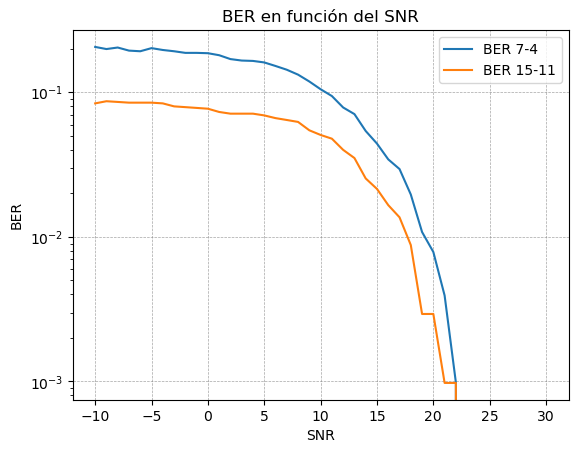

In [8]:
#Archivo de excel con los datos obtenidos por el código ber_calculation.py
archivo_ber = 'snr_ambas_variantes.xlsx'
#Dataframe el BER para 15-11 y 7-4 tras el barrido de SNR
data_ber = pd.read_excel(archivo_ber)

#Etiquetas en los ejes
plt.ylabel('BER')
plt.xlabel('SNR')
#Titulo del gráfico
plt.title('BER en función del SNR')

#Se grafican los valores de BER para ambas Hamming 7-4 y 15-11 tras realizar el barrido de SNR
plt.semilogy(data_ber['SNR'],data_ber['BER_74'],label="BER 7-4")
plt.semilogy(data_ber['SNR'],data_ber['BER_1511'],label="BER 15-11")



#Se activa el grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

#Se muestra la leyenda de las gráficas
plt.legend()

###  Gráfico de Latidos por Minutos

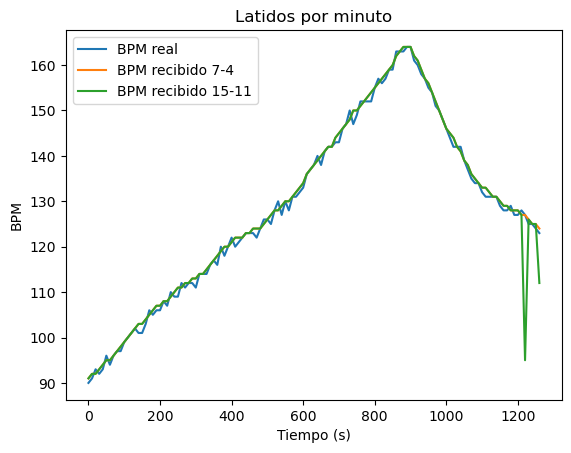

In [9]:
plt.ylabel('BPM')
plt.xlabel('Tiempo (s)')
plt.title('Latidos por minuto')

plt.plot(tiempo,data_reales['BPM'],label="BPM real")
plt.plot(tiempo,data_deco74,label="BPM recibido 7-4")
plt.plot(tiempo,data_deco1511['BPM_Decodificados_15_11'],label="BPM recibido 15-11")

plt.legend()

In [10]:
# BPM de los valores reales
BPM_true = data_reales['BPM']

# BPM de la decodificación 7-4 
BPM_pred_74 = data_deco74

# BPM de la decodificación 15-11 
BPM_pred_1511 = data_deco1511['BPM_Decodificados_15_11']  

#### RMSE

In [11]:
#Se calcula el RMSE de la decodificación 7-4
MSE_74 = mean_squared_error(BPM_true,BPM_pred_74)
RMSE_74 = math.sqrt(MSE_74)

#Se calcula el RMSE de la decodificación 15-11
MSE_1511= mean_squared_error(BPM_true,BPM_pred_1511)
RMSE_1511 = math.sqrt(MSE_1511)

print("El RMSE de la decodificación 7-4 es:", RMSE_74)
print("El RMSE de la decodificación 15-11 es:", RMSE_1511)

El RMSE de la decodificación 7-4 es: 1.0574073180286168
El RMSE de la decodificación 15-11 es: 3.1821351718568627


#### Pbias

In [12]:
#Se calcula el Pbias de la decodificación 7-4
pbias_74 = spotpy.objectivefunctions.pbias(BPM_true,BPM_pred_74)

#Se calcula el Pbias de la decodificación 15-11
pbias_1511 = spotpy.objectivefunctions.pbias(BPM_true,BPM_pred_1511)

print("El Pbias de la decodificación 7-4 es:", pbias_74)
print("El Pbias de la decodificación 15-11 es:", pbias_1511)

El Pbias de la decodificación 7-4 es: 48.19439343860938
El Pbias de la decodificación 15-11 es: 0.11017260374586854
